In [1]:
using DrWatson
@quickactivate :SwARExperiments

In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [3]:
using Plots
using PGFPlotsX
using LaTeXStrings
using ColorSchemes
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

## Switching AR

## Generate AR

In [4]:
seed = 2
n_samples = 5000
n_states = 2
ar_order = 2
l_slice = 100
n_buckets = div(n_samples, l_slice)

coefs_set = [generate_coefficients(seed*i,  ar_order) for i in 1:n_states]
prec_set  = sample(MersenneTwister(seed), [0.1, 1.0, 10.0, 100.0, 1000.0], n_states, replace=false)

gen_A, gen_states, observations = generateSwAR(seed, n_samples, l_slice, n_states, ones(n_states), coefs_set, prec_set)
inputs, outputs = observations[1], observations[2];

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.000000000000002, b=100.0), GammaShapeRate{Float64}(a=100000.0, b=10000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [10000.0 10000.0; 10000.0 10000.0])

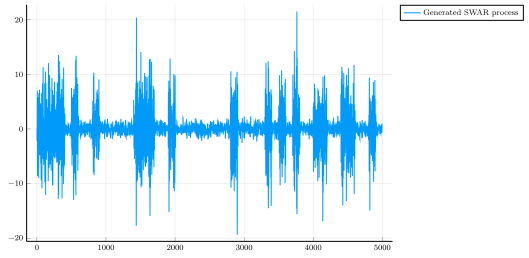

In [5]:
plot(outputs, label="Generated SWAR process")

In [6]:
plt_swar = @pgf Axis({
    title="Generated SWAR process",
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    grid="major",
    xmin=0.0, xmax=5000,
    yminorgrids=true,
    tick_align="outside",
    scaled_y_ticks = false,
    xlabel=L"t", ylabel="value"
},
Plot({no_marks,color="orange"}, Coordinates(collect(1:length(outputs)), outputs)))
display(plt_swar)

Process(`open /var/folders/8n/rnpdqdwj53nd09r6r7qwc_bc0000gn/T/jl_cNy80n.pdf`, ProcessRunning)

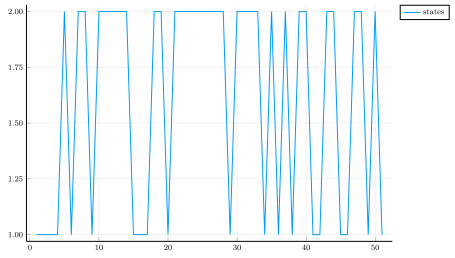

In [7]:
real_states = last.(findmax.(gen_states))
plot(real_states, label="states")

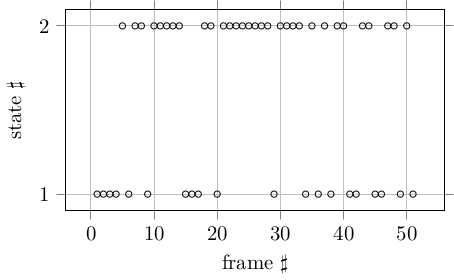

In [8]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    grid="major",
    yminorgrids=true,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="8cm", height="5cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=1.5, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        ),
    ))

In [9]:
gen_A

2×2 Matrix{Float64}:
 0.244035  0.366421
 0.755965  0.633579

In [10]:
using FFTW
plot(abs.(fft(outputs)).^2, label=false)

LoadError: ArgumentError: Package FFTW not found in current path:
- Run `import Pkg; Pkg.add("FFTW")` to install the FFTW package.


In [11]:
# csep = 1000.0

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.000000000000002, b=100.0), GammaShapeRate{Float64}(a=100000.0, b=10000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [10000.0 10000.0; 10000.0 10000.0])

In [12]:
mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_swar(inputs, outputs, 50, 20, parameters);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [13]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.499912  0.499836
 0.500088  0.500164

In [14]:
gen_A

2×2 Matrix{Float64}:
 0.244035  0.366421
 0.755965  0.633579

In [15]:
mean.(mθs[end])

50-element Vector{Vector{Float64}}:
 [0.6673951547574608, -0.6329497794046307]
 [0.6960439455507497, -0.7406514786623147]
 [0.7775116213803915, -0.6560806250463711]
 [0.7304704388317549, -0.770907355772655]
 [1.2854027678422957, -0.6348883187478326]
 [0.9123298131908582, -0.6371439816813873]
 [1.3428910420330469, -0.6997028271707973]
 [1.3255967959377868, -0.6447583954973811]
 [0.7236850651829657, -0.6360772375307342]
 [1.4021311426333274, -0.7863456316569061]
 [1.3028351561130855, -0.6764825657867285]
 [1.2029348659202102, -0.6033330762697722]
 [1.3859416948968164, -0.7425356986854044]
 ⋮
 [1.3351255433791236, -0.680478435343375]
 [1.3737100058861489, -0.7355418270877728]
 [0.6746178807507249, -0.6465284642002712]
 [0.7623757019517267, -0.7093841467526466]
 [1.3297100220109876, -0.6990927886162204]
 [1.2978435775478108, -0.6794600748125021]
 [0.69684911510067, -0.7111323569457282]
 [0.653858283379846, -0.659166904945572]
 [1.379129810911072, -0.7801899491596491]
 [1.3515125092640192, 

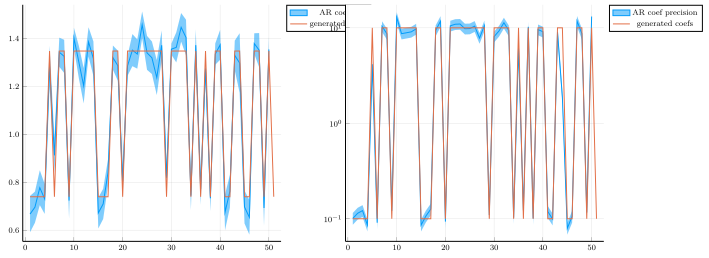

In [21]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

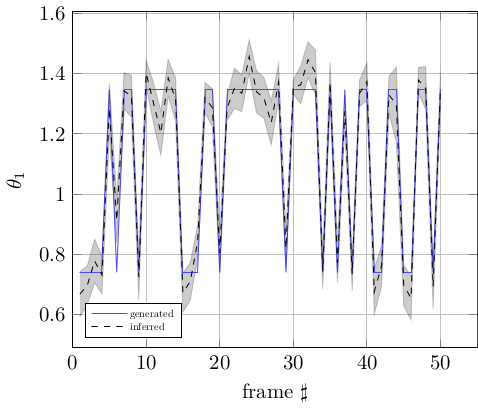

In [17]:
index = 1
dimension(n) = (x) -> map(i -> i[n], x)

plt_states = @pgf Axis(
    {   xlabel="frame "*L" \sharp",
        xmin=0.0,
        legend_pos = "south west",
        legend_cell_align="{left}",
        grid = "major",
        ylabel=L"\theta_{1}",
        legend_style = "{nodes={scale=0.5, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [coefs_set[state][index] for state in real_states[1:end-1]])), LegendEntry("generated"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(mθs[end]) |> dimension(index))),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), (mean.(mθs[end]) |> dimension(index)) .+  (sqrt.(var.(mθs[end]) |> dimension(index))) )),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_buckets), (mean.(mθs[end]) |> dimension(index)) .-  (sqrt.(var.(mθs[end]) |> dimension(index))) )),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)


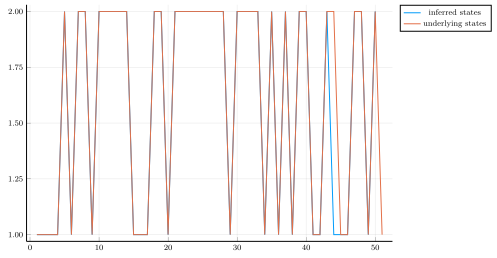

In [18]:
real_states = last.(findmax.(gen_states))
plot(round.(mean.(mzs[end][1:end])), label="inferred states")
plot!(real_states, label="underlying states")

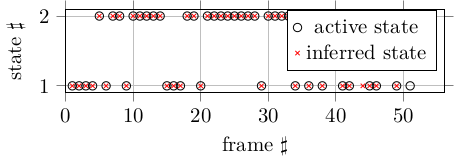

In [41]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    grid="major",
    yminorgrids=true,
    xmin=0.0,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="10cm", height="3cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=2.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        )
    ), LegendEntry("active state"),
Plot(
    {fill="black", only_marks,color="red", mark_size=1.5, opacity=1.0, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(mzs[end])), y = round.(mean.(mzs[end][1:end]))
        ),
    ), LegendEntry("inferred state"),
)



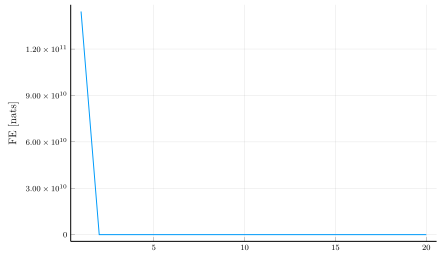

In [20]:
plot(mfe[1:end], label=:none, ylabel="FE [nats]")